In [47]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

import sklearn
from sklearn.tree import export_graphviz
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn.utils import shuffle
from sklearn import svm

from IPython.display import SVG

import csv
import os 
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import scipy as sp
import PIL

In [75]:

# assuming data is contained in a train and a validation set
train_data_dir = 'trainingdata/'

# Set up some parmaeters for data loading
sample_rate = 0.25

# desired dimensions of our images.
img_width, img_height = 150, 150

# Set input shape
input_shape = (img_width, img_height, 3)

Load image data

In [76]:
num_classes = 4

# Initialise arrays for data storage
X_data = np.ndarray((0, input_shape[0], input_shape[1], input_shape[2]), dtype=np.float)
y_data= np.ndarray(0, dtype=np.float)


# generate filenames from the data folder and do sampling
image_filenames = [train_data_dir+i for i in os.listdir(train_data_dir) if not i.startswith('.')] # use this for full dataset
#print(image_filenames)

##uncomment to sample
image_filenames = random.sample(image_filenames, int(len(image_filenames)*sample_rate))

#     # Create a data array for image data
count = len(image_filenames)
X_data_part = np.ndarray((count, input_shape[0], input_shape[1], input_shape[2]), dtype=np.float)

# Iterate throuigh the filenames and for each one load the image, resize and normalise
for i, image_file in enumerate(image_filenames):
    # Low the images and resize them
    image = cv2.imread(image_file, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (img_height, img_width), interpolation=cv2.INTER_CUBIC)
    image = image[:,:,[2,1,0]] # OpenCV and matplotlib use differnet channel oerderings so fix this
            
#   # Add image data to data array and normalise
    X_data_part[i] = image
    X_data_part[i] = X_data_part[i]/255
    
#     print(image_file[-6])
    # Add label to label array
    y_data = np.append(y_data, image_file[-6])

print('Processed {} images'.format(i+1))
    
# Append the part to the overall data array
X_data = np.append(X_data, X_data_part, axis=0)
    
print("Data shape: {}".format(X_data.shape))

Processed 10312 images
Data shape: (10312, 150, 150, 3)


In [77]:
# Perfrom split to train, validation, test
X_train_plus_valid, X_test, y_train_plus_valid, y_test = train_test_split(X_data, y_data, random_state=0, test_size = 0.30, train_size = 0.7)

# Perfrom split to train, validation, test
X_train, X_valid, y_train, y_valid = train_test_split(X_train_plus_valid, y_train_plus_valid, random_state=0, test_size = 0.20, train_size = 0.8)

In [78]:
y_train_wide = to_categorical(y_train, num_classes)
y_test_wide = to_categorical(y_test, num_classes)
y_valid_wide = to_categorical(y_valid, num_classes)

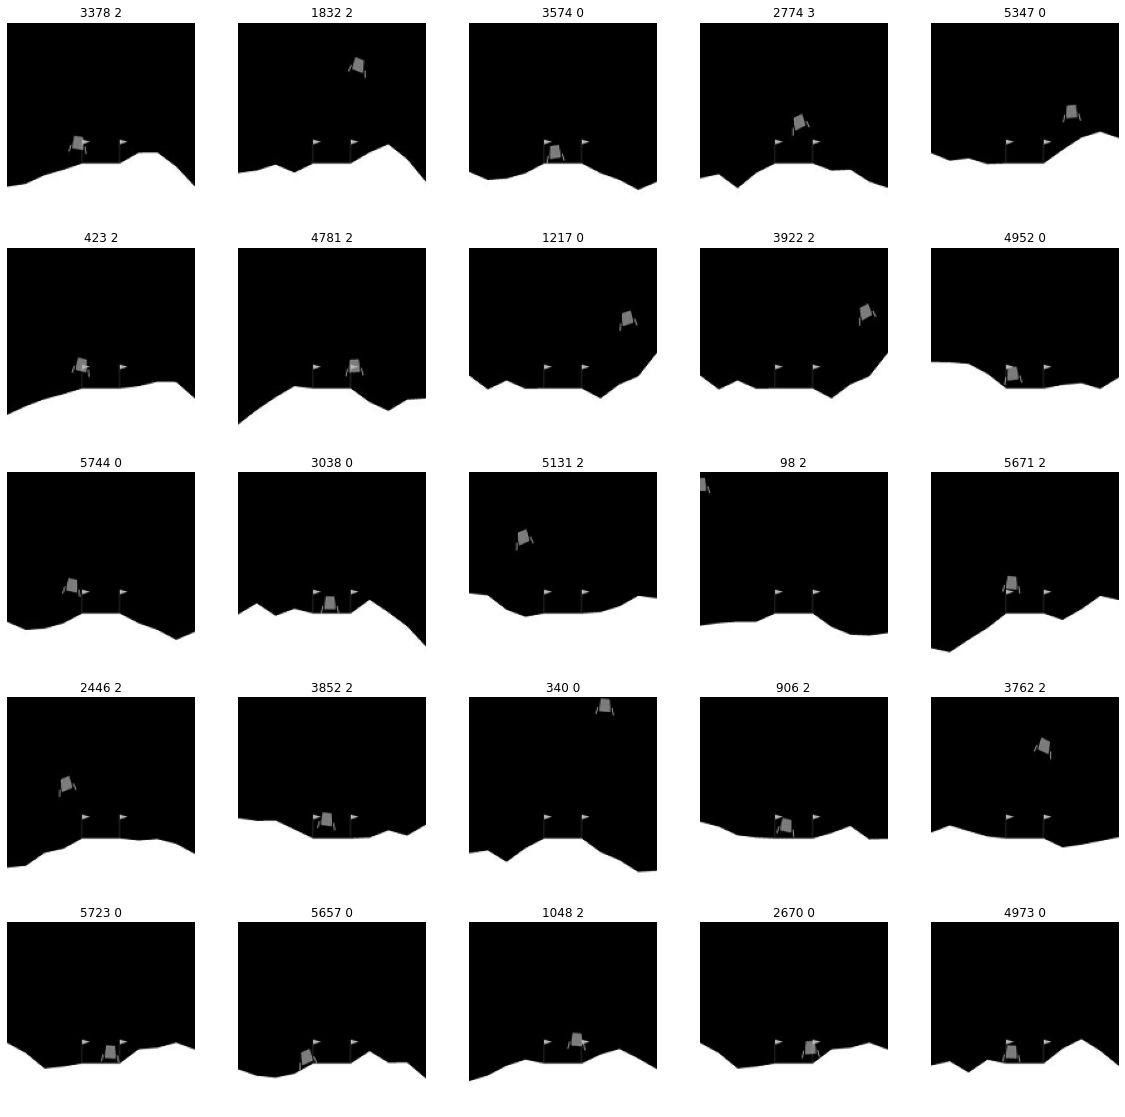

In [79]:
pltsize=4
row_images = 5
col_images = 5
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(row_images * col_images):
    i_rand = random.randint(0, X_train.shape[0])
    plt.subplot(row_images,col_images,i+1)
    plt.axis('off')
    plt.imshow(PIL.Image.fromarray(((X_train[i_rand]) * 255).astype(np.uint8)))
    plt.title((str(i_rand) + " " + y_train[i_rand]))

In [80]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
activation_23 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_24 (Activation)   (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 34, 34, 64)       

In [81]:
batch_size = 128
epochs = 10

# Set up the callback to save the best model based on validaion data
best_weights_filepath = './best_weights_notebook21.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_accuracy",
                      save_best_only=True, save_weights_only=False)

history = model.fit(X_train, y_train_wide,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          validation_split = 0.2,
          shuffle=True,
          callbacks=[mcp])

#reload best weights
model.load_weights(best_weights_filepath)

Epoch 1/10
37/37 [==============================] - 32s 827ms/step - loss: 0.4615 - accuracy: 0.4934 - val_loss: 0.3741 - val_accuracy: 0.6450
Epoch 2/10
37/37 [==============================] - 30s 818ms/step - loss: 0.3713 - accuracy: 0.6445 - val_loss: 0.3566 - val_accuracy: 0.6424
Epoch 3/10
37/37 [==============================] - 29s 784ms/step - loss: 0.3529 - accuracy: 0.6620 - val_loss: 0.3258 - val_accuracy: 0.7004
Epoch 4/10
37/37 [==============================] - 28s 767ms/step - loss: 0.3375 - accuracy: 0.6821 - val_loss: 0.3222 - val_accuracy: 0.6866
Epoch 5/10
37/37 [==============================] - 29s 780ms/step - loss: 0.3300 - accuracy: 0.6895 - val_loss: 0.3219 - val_accuracy: 0.6771
Epoch 6/10
37/37 [==============================] - 28s 767ms/step - loss: 0.3167 - accuracy: 0.6945 - val_loss: 0.3185 - val_accuracy: 0.7134
Epoch 7/10
37/37 [==============================] - 28s 765ms/step - loss: 0.3122 - accuracy: 0.7052 - val_loss: 0.3207 - val_accuracy: 0.6996

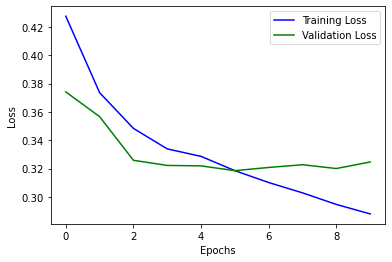

In [82]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

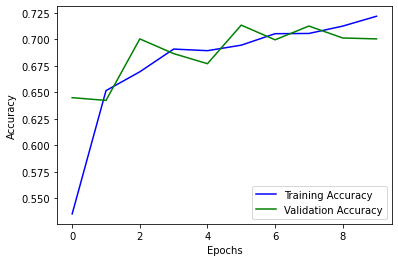

In [83]:
loss = history.history['accuracy']
val_loss = history.history['val_accuracy']

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(loss, 'blue', label='Training Accuracy')
plt.plot(val_loss, 'green', label='Validation Accuracy')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

In [84]:
# Make a set of predictions for the training data
pred = model.predict_classes(X_train)

# Print performance details
print(metrics.classification_report(y_train.astype('float64'), pred))
print("Confusion matrix")
print(metrics.confusion_matrix(y_train.astype('float64'), pred))


              precision    recall  f1-score   support

         0.0       0.85      0.54      0.66      2663
         1.0       0.00      0.00      0.00       177
         2.0       0.65      0.95      0.77      2750
         3.0       0.62      0.03      0.05       184

    accuracy                           0.71      5774
   macro avg       0.53      0.38      0.37      5774
weighted avg       0.72      0.71      0.67      5774

Confusion matrix
[[1450    0 1211    2]
 [  57    0  120    0]
 [ 126    0 2623    1]
 [  81    0   98    5]]


In [85]:
# Make a set of predictions for the test data
pred = model.predict_classes(X_test)

# Print performance details
print(metrics.classification_report(y_test.astype('float64'), pred))
print("Confusion matrix")
print(metrics.confusion_matrix(y_test.astype('float64'), pred))

              precision    recall  f1-score   support

         0.0       0.81      0.52      0.63      1464
         1.0       0.00      0.00      0.00       107
         2.0       0.62      0.94      0.75      1428
         3.0       0.00      0.00      0.00        95

    accuracy                           0.68      3094
   macro avg       0.36      0.36      0.34      3094
weighted avg       0.67      0.68      0.64      3094

Confusion matrix
[[ 760    0  702    2]
 [  49    0   58    0]
 [  90    0 1338    0]
 [  42    0   53    0]]


Draw some examples of correct classifications 

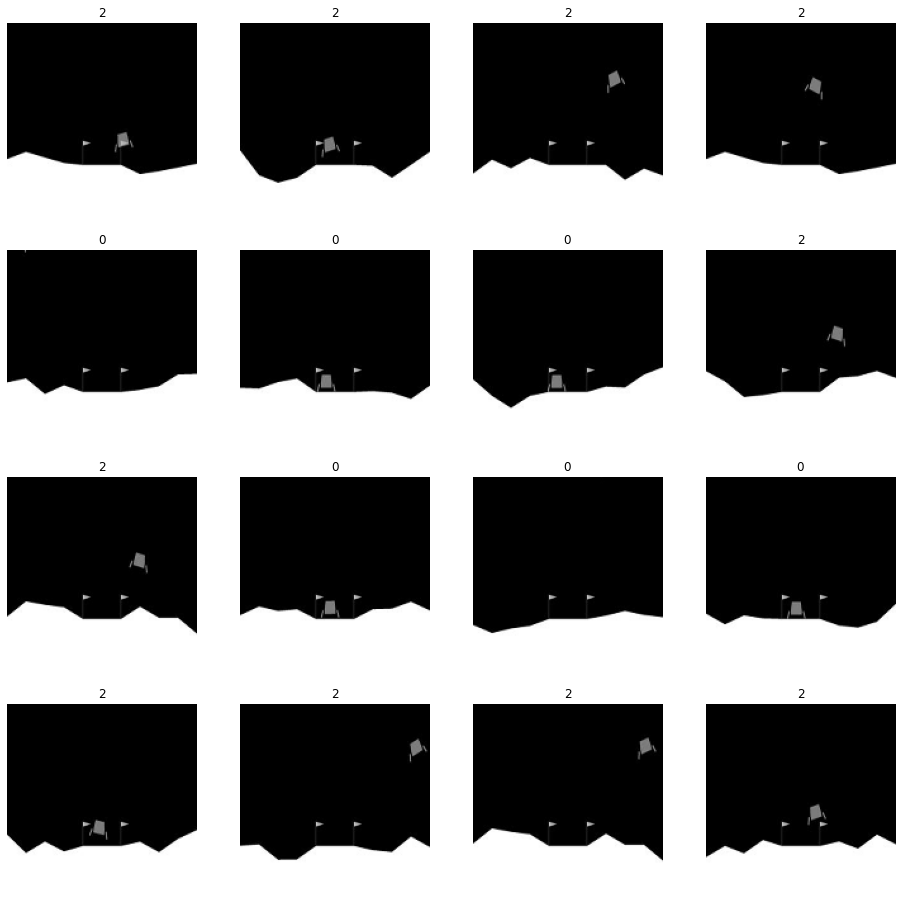

In [86]:
pltsize=4
row_images = 4
col_images = 4

maxtoshow = row_images * col_images
predictions = pred.reshape(-1)
corrects = predictions == y_test.astype('float64')
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(X_test.shape[0]):
    if ii>=maxtoshow:
        break
    if corrects[i]:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray(((X_test[i]) * 255).astype(np.uint8)))
        plt.title("{}".format(y_test[i]))
        ii = ii + 1

Draw some examples of mis-classifications 

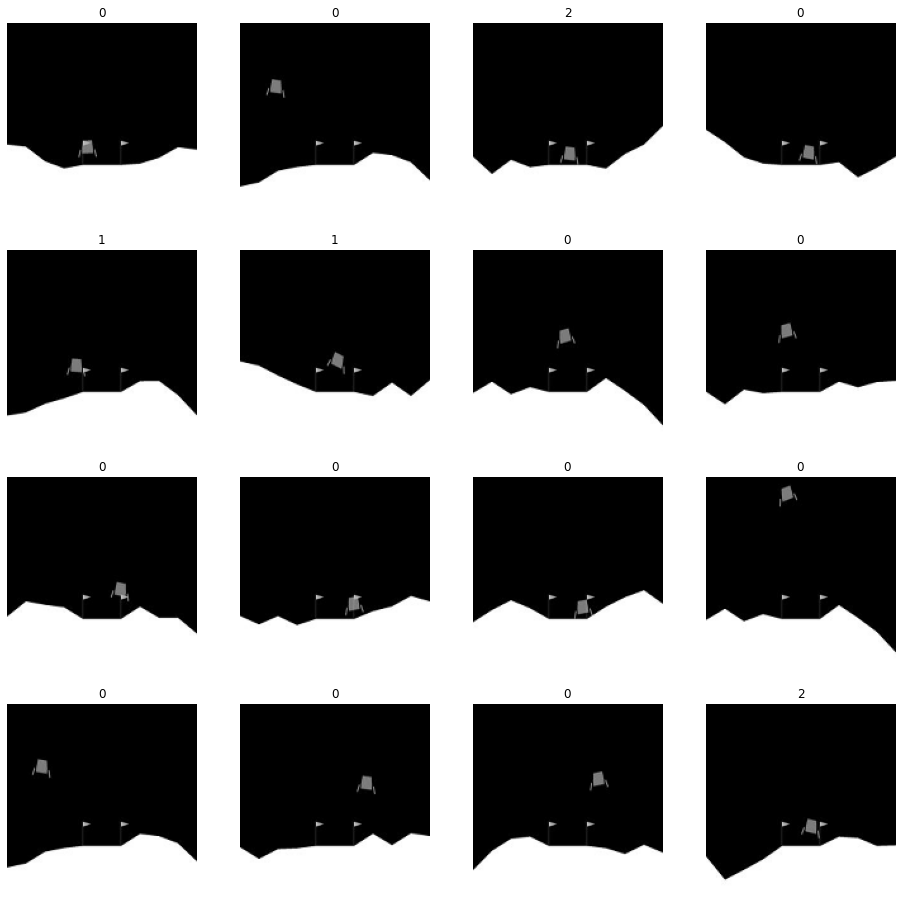

In [87]:
pltsize=4
row_images = 4
col_images = 4

maxtoshow = row_images * col_images
predictions = pred.reshape(-1)
errors = predictions != y_test.astype('float64')
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(X_test.shape[0]):
    if ii>=maxtoshow:
        break
    if errors[i]:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray(((X_test[i]) * 255).astype(np.uint8)))
        plt.title("{}".format(y_test[i]))
        ii = ii + 1

## Data Augmentation

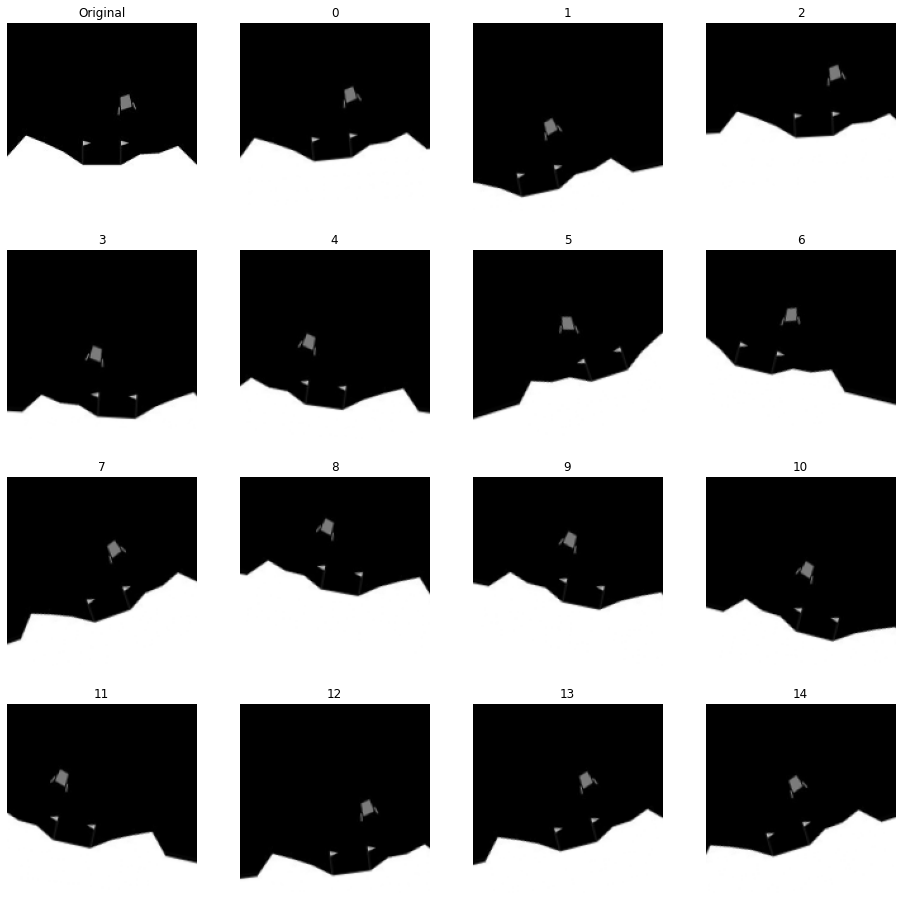

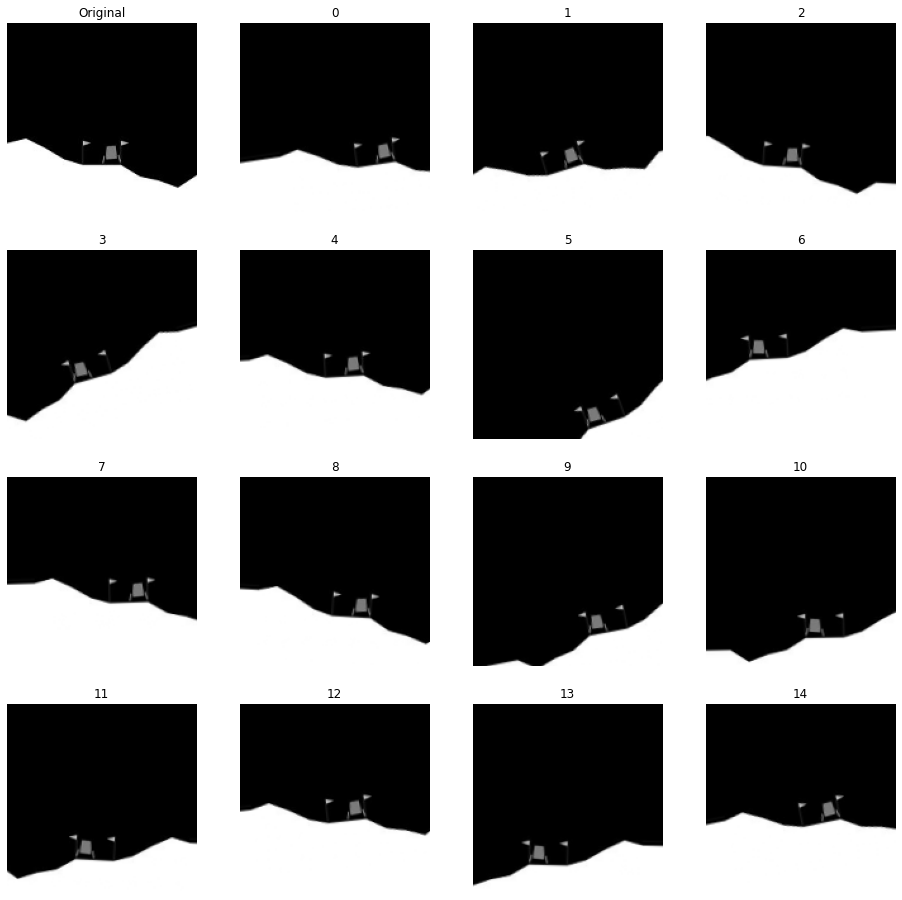

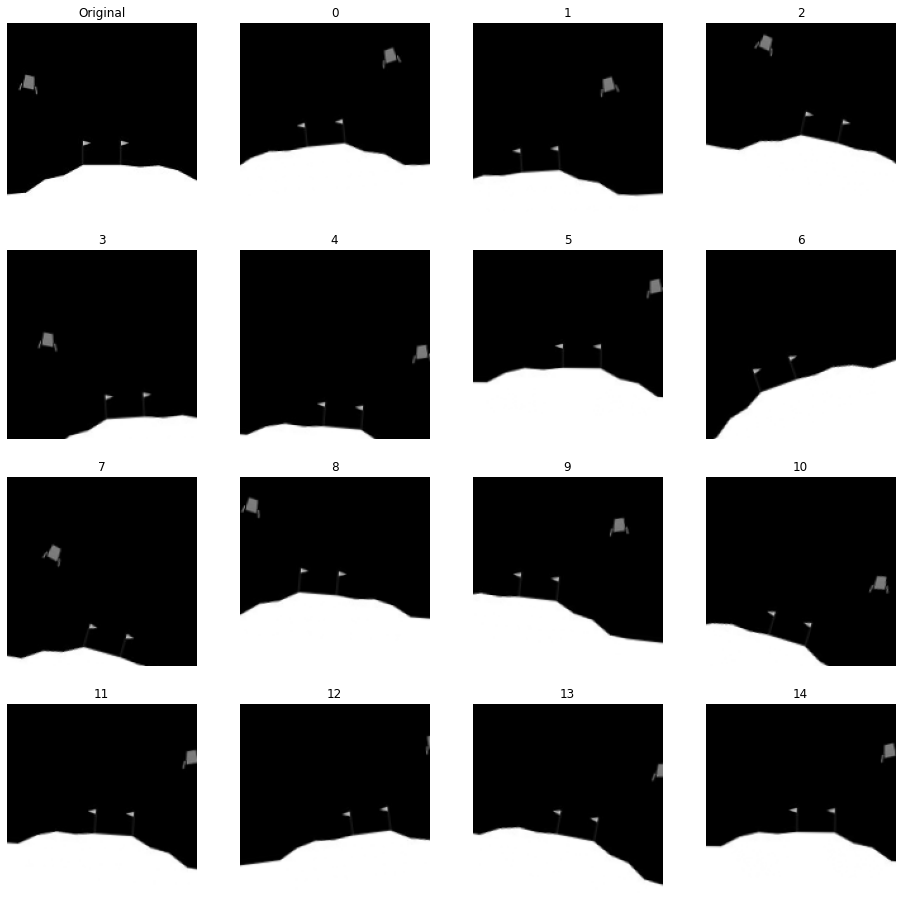

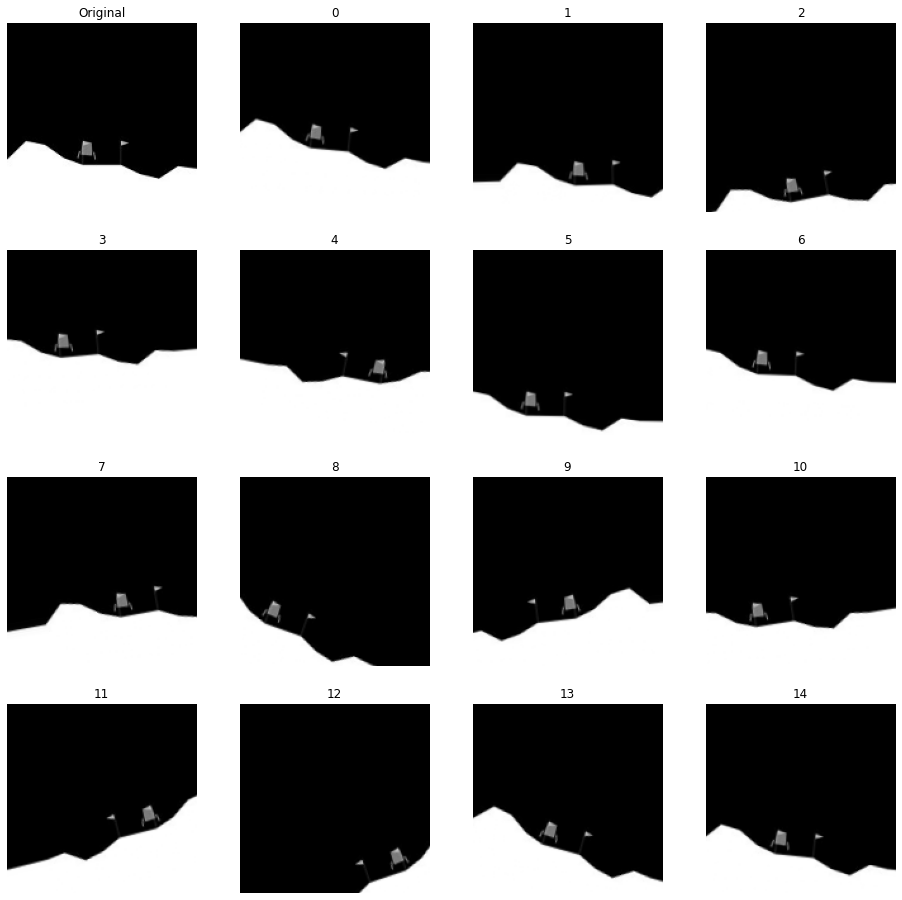

In [88]:
pltsize=4
row_images = 4
col_images = 4

# Create a transformed data generator
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

# fit parameters from data
datagen.fit(X_train)

for idx in range(0, 4):
    # Plot the original image
    plt.figure(figsize=(col_images*pltsize, row_images*pltsize))
    plt.subplot(row_images,col_images,1)
    plt.axis('off')
    plt.imshow(PIL.Image.fromarray(((X_train[idx]) * 255).astype(np.uint8)))
    plt.title("Original")

    for i in range(row_images * col_images - 1):
        rand_trans = datagen.random_transform(X_train[idx])
        plt.subplot(row_images,col_images,i+2)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray(((rand_trans) * 255).astype(np.uint8)))
        plt.title(i)

    plt.show()                             

In [89]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation = 'softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
activation_28 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_29 (Activation)   (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 34, 34, 64)       

In [ ]:
batch_size = 128
epochs = 10

# Set up the callback to save the best model based on validaion data
best_weights_filepath = './best_weights_notebook22.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_loss",
                      save_best_only=True, save_weights_only=False)

# Create a data generator for the trianing data
datagen_train = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
datagen_train.fit(X_train)
        
history = model.fit_generator(datagen_train.flow(X_train, y_train_wide, batch_size=batch_size),
          steps_per_epoch=len(X_train) / batch_size,
          validation_data=(X_valid, y_valid_wide),
          epochs=epochs,
          verbose = 1,
          shuffle=True,
          callbacks=[mcp])

#reload best weights
model.load_weights(best_weights_filepath)

/Users/finolacahill/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
45/45 [==============================] - 48s 1s/step - loss: 0.4696 - accuracy: 0.4450 - val_loss: 0.4211 - val_accuracy: 0.4917
Epoch 2/10
45/45 [==============================] - 47s 1s/step - loss: 0.4230 - accuracy: 0.4987 - val_loss: 0.4046 - val_accuracy: 0.5180
Epoch 3/10
45/45 [==============================] - 47s 1s/step - loss: 0.4098 - accuracy: 0.5520 - val_loss: 0.3926 - val_accuracy: 0.6482
Epoch 4/10
45/45 [==============================] - 55s 1s/step - loss: 0.4058 - accuracy: 0.5663 - val_loss: 0.3814 - val_accuracy: 0.6475
Epoch 5/10
45/45 [==============================] - 60s 1s/step - loss: 0.3982 - accuracy: 0.6121 - val_loss: 0.3751 - val_accuracy: 0.6461
Epoch 6/10
45/45 [==============================] - 54s 1s/step - loss: 0.3896 - accuracy: 0.6174 - val_loss: 0.3951 - val_accuracy: 0.6738
Epoch 7/10
45/45 [==============================] - 49s 1s/step - loss: 0.3795 - accuracy: 0.6425 - val_loss: 0.3612 - val_accuracy: 0.6884
Epoch 8/10
44/45 [==